# Comparison against Maximum Matching
This notebook compares the assignment of max matching with our potential-based method.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import cvxpy
from scipy.spatial.distance import cdist
pop_scaling_factor = (100979303/76413657)*0.02

## Loading data

In [4]:
df_elem = gpd.read_file("data/elem_schools_ncr_summary.geojson")
barangays = gpd.read_file("data/barangays_ncr_summary.geojson")


crs = {"init":"epsg:32651"}
df_elem = df_elem.to_crs(crs=crs)
barangays = barangays.to_crs(crs=crs)

## Maximum Matching problem
We pose a matching problem (similar to [Assignment Problem](https://en.wikipedia.org/wiki/Assignment_problem)) with some modifications: we want to assign enrolled students to a Most Local Administrative Unit (MLAU), which in this particular example is a barangay, while minimizing the distance from a school to the MLAU's centroid.
The only constraint is that the number of students in the MLAU should not exceed the MLAU's population.

In [5]:
Dist_matrix = cdist(list(zip(df_elem.geometry.x, df_elem.geometry.y)),
      list(zip(barangays.geometry.centroid.x, barangays.geometry.centroid.y)))
B = cvxpy.Variable(Dist_matrix.shape, integer=True)
student_constraint = cvxpy.sum(B, axis=1) == df_elem["Grade 6 Total 2015"]
positive_constraint = B >= 0
population_constraint = cvxpy.sum(B, axis=0) <= (barangays["POP2K"]*pop_scaling_factor).astype(int)
problem = cvxpy.Problem(cvxpy.Minimize(cvxpy.sum(cvxpy.multiply(B,Dist_matrix))), 
                        [student_constraint, positive_constraint, population_constraint])

# Solving the problem
cost_func = problem.solve(solver=cvxpy.GLPK_MI, verbose=True, parallel=True)


## Potential-based assignment

In [8]:
def students_in_barangay_weighted(df, barangays_df, column = "Grade 6 Total 2015", alpha=1, R_c=1): 
    r_matrix = cdist(list(zip(df.geometry.x, df.geometry.y)),
                      list(zip(barangays_df.geometry.centroid.x, barangays_df.geometry.centroid.y)))
    kernel = np.clip(((r_matrix/R_c)+1e-10)**-alpha, a_min=0, a_max=1)*(barangays_df.POP2K).values
    return ((kernel.T * np.array(df.loc[:, column])) / np.sum(kernel, axis = 1)).T

In [9]:
assignment_potential = students_in_barangay_weighted(df_elem, barangays, alpha=4, R_c=5e3)
assignment_potential = np.round(assignment_potential)

In [10]:
matching = B.value.flatten()
potential = assignment_potential.flatten()
distances = Dist_matrix.flatten()
np.savez("data/matching_comparison.npz", matching=matching, potential=potential, distances=distances)

## Comparison of results

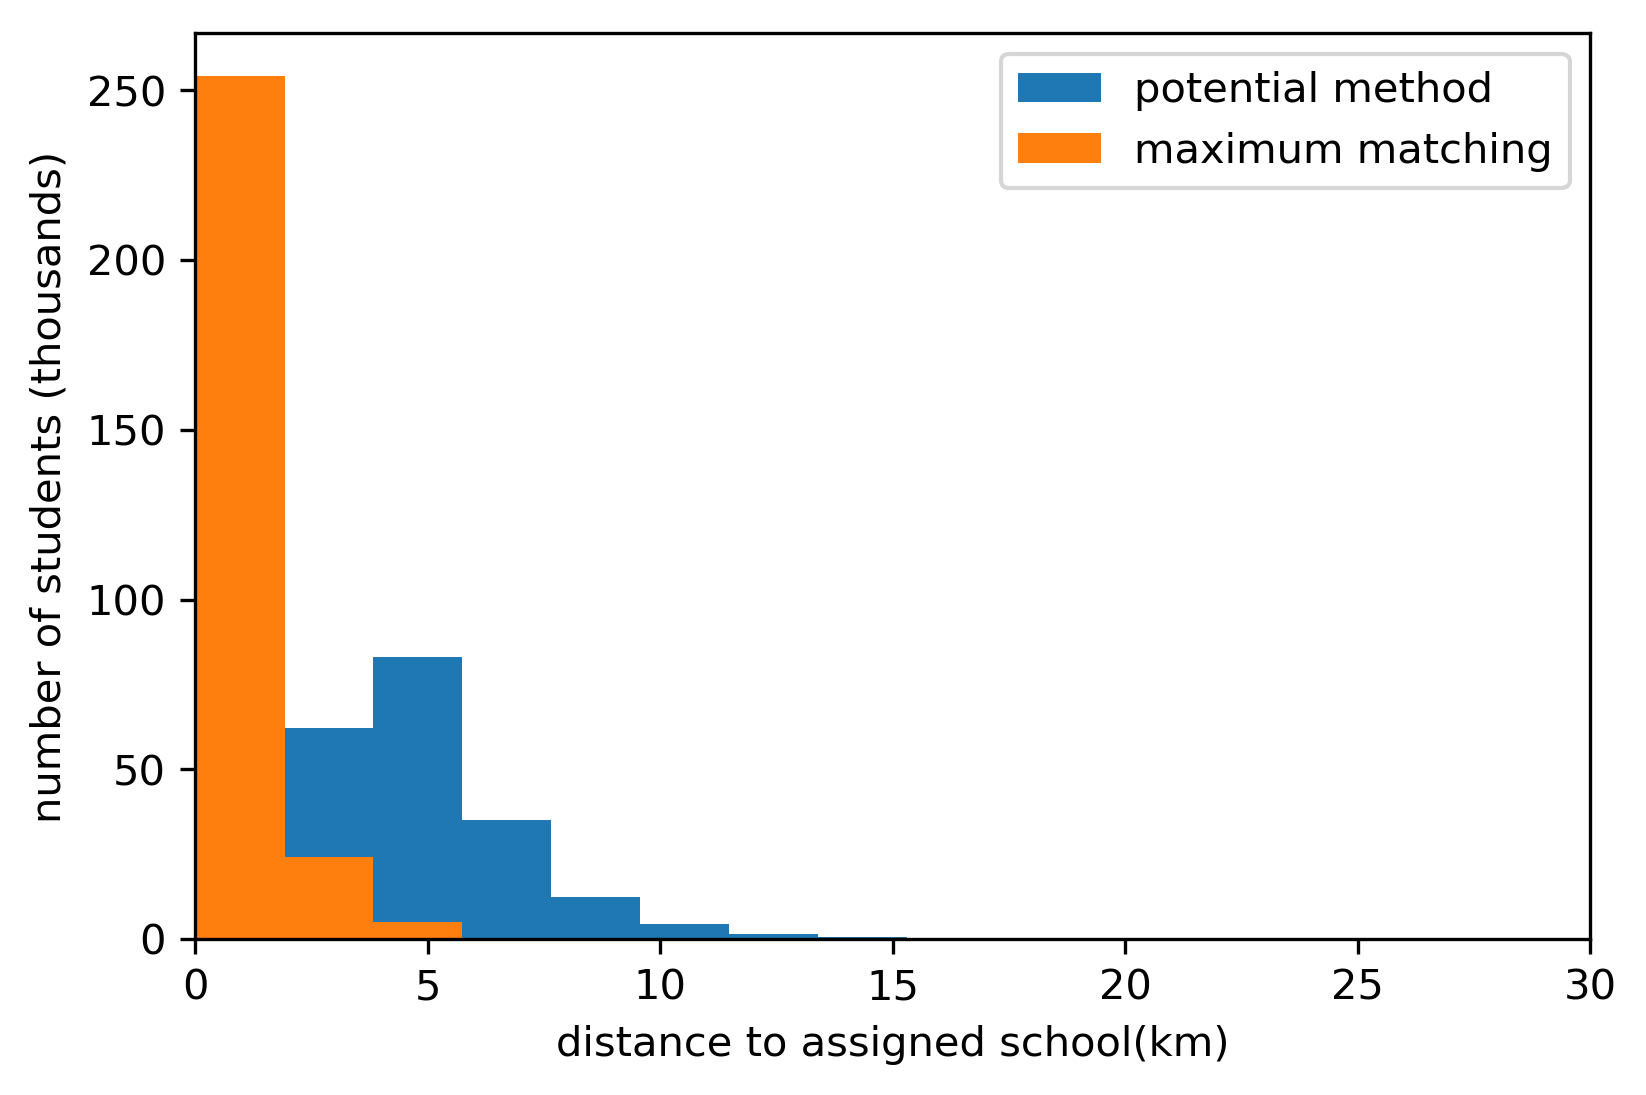

In [11]:
temp = np.load("data/matching_comparison.npz")
distances = temp['distances']
potential = temp['potential']
matching = temp['matching']

fig, ax = plt.subplots(1,1, dpi=300)
ax.hist(distances/1000, weights=potential/1000, bins=50, label="potential method")
ax.hist(distances/1000, weights=matching/1000, bins=50, label="maximum matching")
ax.set_xlabel("distance to assigned school(km)")
ax.set_xlim(0, 30)
ax.set_ylabel("number of students (thousands)")
plt.legend()

In [13]:
barangays.head()

,POP2K,geometry
0,1947,"POLYGON ((284745.3922947345 1615698.637868176,..."
1,1001,"POLYGON ((282440.6503678477 1615419.220052137,..."
2,1051,"POLYGON ((283107.9379078645 1611471.591931188,..."
3,1444,"POLYGON ((283886.3541798402 1610869.436447737,..."
4,767,"POLYGON ((283320.3833063719 1611312.564814992,..."
